C://Users//91829//Desktop//Project 7th Sem//Audio_Speech_Actors_01-24//Actor_18//03-01-01-01-01-02-18.wav




C:\Users\91829\AppData\Local\Temp\ipykernel_13056\3297348015.py:132: FutureWarning:

Pass y=[ 1.9985920e-07 -9.0237984e-07  2.5921149e-06 ...  5.4710963e-05
  2.2816404e-05  1.9574939e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error



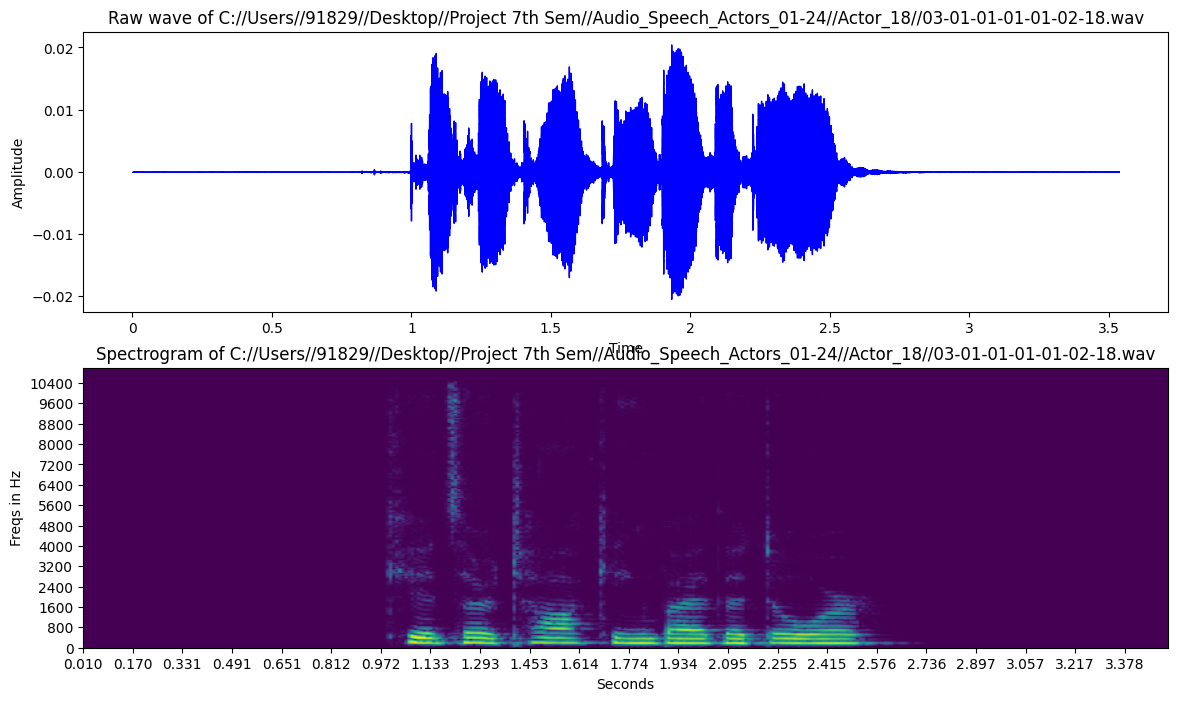

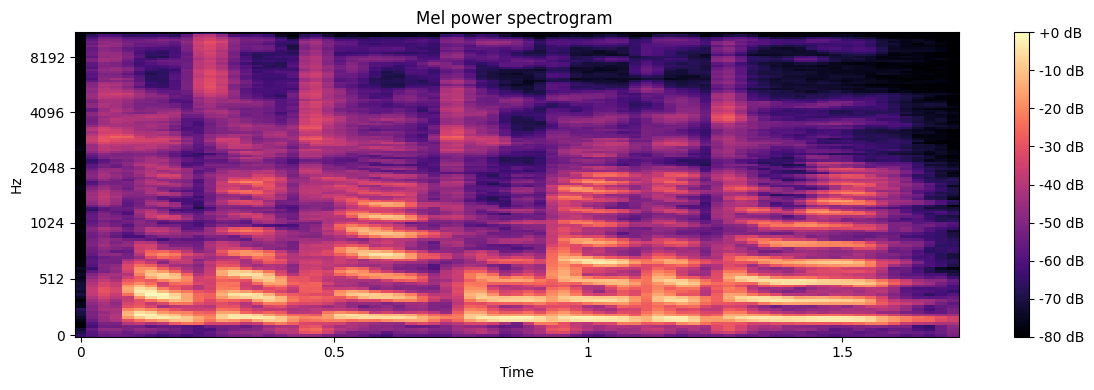

In [1]:
import os
import random
import sys


## Package
import glob 
from tensorflow import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical 
## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

dir_list = os.listdir('C://Users//91829//Desktop//Project 7th Sem//Audio_Speech_Actors_01-24')
dir_list.sort()


data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('C://Users//91829//Desktop//Project 7th Sem//Audio_Speech_Actors_01-24//' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'C://Users//91829//Desktop//Project 7th Sem//Audio_Speech_Actors_01-24//' + i + '//' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

data_df.head(25) 
     
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

sample_rate/ len(samples)

freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
sr = sample_rate
librosa.display.waveshow(samples, sr = sr, color= "blue")
print("\n")

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

aa , bb = librosa.effects.trim(samples, top_db=30)
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)


plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()




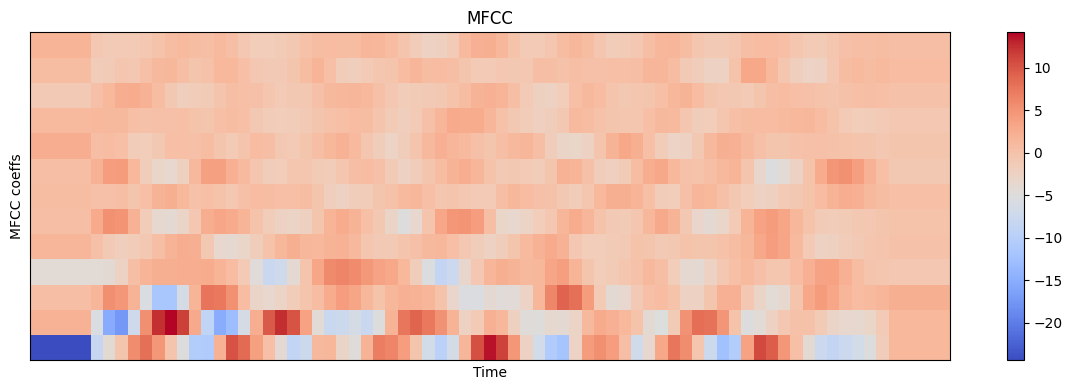

In [2]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [3]:
ipd.Audio(samples, rate=sample_rate)
ipd.Audio(aa, rate=sample_rate)
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [4]:
label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"

In [5]:
label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1

In [6]:
label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Adding gender  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [7]:
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [8]:
label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        

    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [9]:
data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,0,1,male_neutral
1,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,1,1,male_neutral
2,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,1,0,1,male_neutral
3,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,1,1,1,male_neutral
4,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,0,2,male_calm


In [10]:
data_df['label']=label5_list
data_df.head()


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,0,1,male_none
1,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,1,1,male_none
2,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,1,0,1,male_none
3,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,1,1,1,male_none
4,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,0,2,male_calm


In [11]:
print (data_df.label.value_counts().keys())


Index(['male_none', 'female_none', 'male_calm', 'male_happy', 'male_sad',
       'male_angry', 'male_fearful', 'female_calm', 'female_happy',
       'female_sad', 'female_angry', 'female_fearful'],
      dtype='object', name='label')


In [12]:
def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    

C:\Users\91829\AppData\Local\Temp\ipykernel_13056\1915501921.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



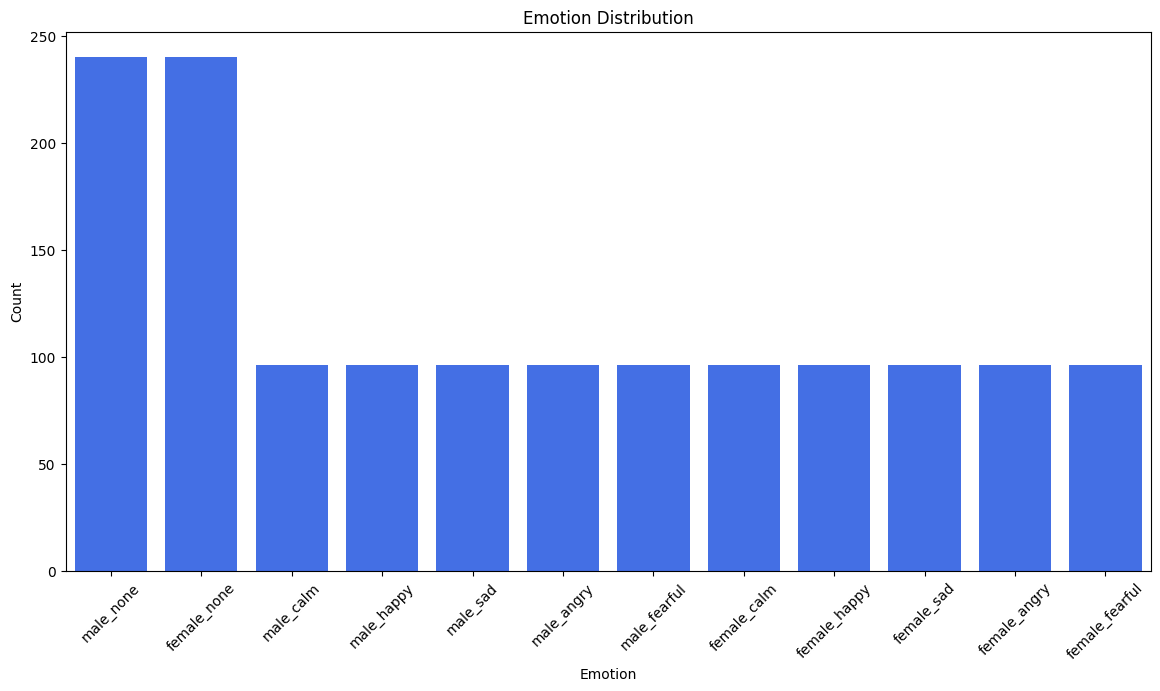

In [13]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [14]:
data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head(50)

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,0,2,male_calm
1,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,1,2,male_calm
2,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,1,0,2,male_calm
3,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,1,1,2,male_calm
4,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,1,0,0,2,male_calm
5,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,1,0,1,2,male_calm
6,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,1,1,0,2,male_calm
7,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,1,1,1,2,male_calm
8,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,0,3,male_happy
9,C://Users//91829//Desktop//Project 7th Sem//Au...,1,1,male,0,0,1,3,male_happy


In [15]:
print (len(data3_df))
data3_df.head(80)

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C://Users//91829//Desktop//Project 7th Sem//Au...,1,21,male,0,0,0,2,male_calm
1,C://Users//91829//Desktop//Project 7th Sem//Au...,1,21,male,0,0,1,2,male_calm
2,C://Users//91829//Desktop//Project 7th Sem//Au...,1,21,male,0,1,0,2,male_calm
3,C://Users//91829//Desktop//Project 7th Sem//Au...,1,21,male,0,1,1,2,male_calm
4,C://Users//91829//Desktop//Project 7th Sem//Au...,1,21,male,1,0,0,2,male_calm
...,...,...,...,...,...,...,...,...,...
75,C://Users//91829//Desktop//Project 7th Sem//Au...,1,23,male,0,1,1,6,male_fearful
76,C://Users//91829//Desktop//Project 7th Sem//Au...,1,23,male,1,0,0,6,male_fearful
77,C://Users//91829//Desktop//Project 7th Sem//Au...,1,23,male,1,0,1,6,male_fearful
78,C://Users//91829//Desktop//Project 7th Sem//Au...,1,23,male,1,1,0,6,male_fearful


In [16]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 26.24it/s]


In [17]:
data.head()

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-67.55767, -67.55767, -67.55767, -67.55767, -..."
2,"[-69.69336, -69.69336, -69.69336, -69.69336, -..."
3,"[-69.051476, -69.051476, -69.051476, -69.05147..."
4,"[-73.84186, -73.84186, -73.84186, -73.72008, -..."


In [18]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-65.447311,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858


In [19]:
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [20]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_calm
5,-69.243607,-69.243607,-69.243607,-69.243607,-68.902382,-67.983444,-68.089653,-67.897789,-65.258499,-67.171410,...,-57.186440,-61.189224,-67.108902,-67.508621,-66.246048,-68.733475,-69.243607,-69.243607,-69.243607,male_calm
6,-73.255318,-73.255318,-73.255318,-73.255318,-68.774933,-69.380905,-73.255318,-73.255318,-73.255318,-73.255318,...,-50.886692,-55.668213,-54.602642,-53.441685,-56.299820,-57.457932,-58.767605,-59.844353,-59.074680,male_calm
7,-70.746674,-70.746674,-70.025597,-69.131645,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,...,-70.746674,-70.746674,-70.079544,-69.590736,-69.203033,-70.159676,-70.445572,-68.199638,-67.593987,male_calm
8,-63.787254,-63.128746,-63.412743,-63.797016,-63.582291,-58.921696,-57.955513,-61.225422,-63.783241,-63.797016,...,-63.740913,-62.410637,-62.489479,-62.494827,-62.633003,-62.878506,NaN,NaN,NaN,male_happy
9,-60.981300,-60.116249,-60.978962,-60.952496,-60.982536,-60.983990,-60.981300,-60.981300,-60.981300,-60.249794,...,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,NaN,NaN,NaN,male_happy


In [21]:
rnewdf.isnull().sum().sum()

2284

In [22]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_calm


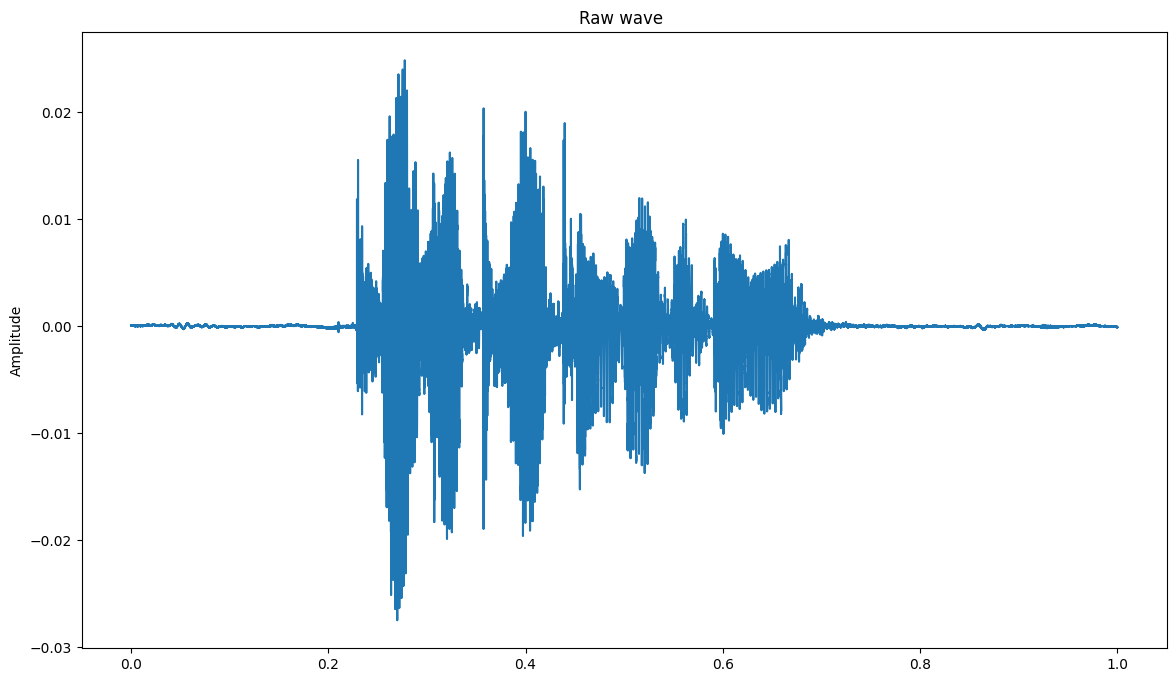

In [23]:
def plot_time_series(data):
   
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
  
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
  
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):

    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
   
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data
accuracy=10
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.3)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

C:\Users\91829\AppData\Local\Temp\ipykernel_13056\501290922.py:34: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error



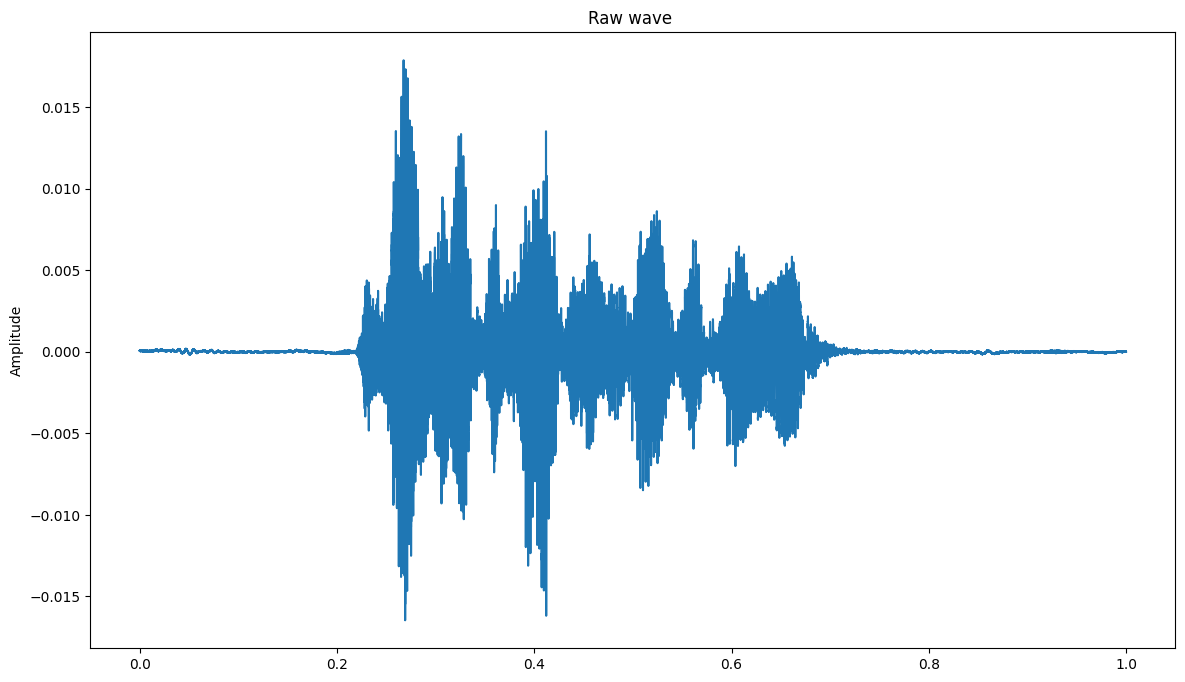

In [24]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [25]:
syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:19<00:00, 20.33it/s]


In [26]:
syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

  0%|                                                                                                                                                                                    | 0/400 [00:00<?, ?it/s]C:\Users\91829\AppData\Local\Temp\ipykernel_13056\501290922.py:34: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  0%|▍                                                                                                                                                                           | 1/400 [00:00<03:22,  1.97it/s]C:\Users\91829\AppData\Local\Temp\ipykernel_13056\501290922.py:34: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  0%|▊                                                                                                                                                                           | 2/400 [00:01<

In [27]:
len(syn_data1), len(syn_data2)

(400, 400)

In [28]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [29]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.505411,-56.402944,-55.299911,-56.991041,-57.343266,-56.961466,-55.599105,-55.858737,-56.445345,-56.892476,...,-53.653924,-56.447162,-58.141494,-58.327377,-58.226614,-56.489767,-56.149091,-54.545829,-57.428561,male_calm
1,-57.207001,-55.495785,-56.354170,-55.676017,-55.239233,-56.708864,-57.306276,-56.774522,-57.268267,-56.451299,...,-58.813317,-57.743972,-56.346846,-58.018121,-58.563682,-57.018668,-56.573432,-56.385100,-57.328147,male_calm
2,-58.402757,-55.965056,-56.061774,-55.593671,-53.992814,-53.229858,-52.682171,-51.570889,-54.200281,-55.299209,...,-54.205417,-54.211089,-53.349586,-53.547401,-54.562087,-54.276429,-53.633484,-54.195225,-55.516690,male_calm
3,-63.921193,-62.291082,-62.534670,-62.861505,-62.615226,-63.141614,-61.330855,-61.530499,-60.703199,-62.036299,...,-63.385288,-62.405354,-63.437227,-63.346407,-61.376977,-62.933302,0.000000,0.000000,0.000000,male_calm
4,-67.845893,-64.678523,-65.303767,-65.045093,-65.171888,-65.057588,-63.905611,-64.812672,-62.610030,-64.349183,...,-62.172486,-60.996993,-63.475170,-65.032769,-63.765595,-63.850926,-65.216187,-66.473117,-67.667060,male_calm


In [30]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [31]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-71.849637,-71.849637,-71.849637,-71.849637,-71.849637,-71.849637,-71.849637,-71.849637,-71.849637,-71.849637,...,-71.849637,-71.750976,-70.855864,-70.973178,-71.849637,-71.671782,-71.352234,-71.799988,-71.849637,male_calm
1,-70.386265,-70.301008,-70.301958,-70.386265,-70.386265,-69.028749,-69.127089,-70.386265,-70.386265,-70.386265,...,-70.386265,-70.386265,-70.386265,-70.386265,-70.386265,-70.386265,-70.386265,-69.891164,-70.342434,male_calm
2,-71.770958,-71.269328,-71.770958,-71.770958,-71.770958,-71.770958,-71.770958,-71.770958,-71.770958,-69.686346,...,-71.770958,-71.770958,-71.770958,-71.770958,-71.550926,-71.770958,-71.770958,-71.770958,-71.770958,male_calm
3,-71.055154,-71.055154,-71.055154,-71.055154,-71.055154,-71.055154,-70.924843,-71.055154,-71.055154,-71.055154,...,-69.552340,-71.055154,-71.055154,-71.055154,-70.970702,-71.055154,0.000000,0.000000,0.000000,male_calm
4,-75.100703,-75.100703,-75.100703,-74.819481,-75.100703,-75.100703,-75.100703,-75.086907,-74.155415,-75.037433,...,-75.100703,-75.100703,-75.100703,-75.100703,-75.100703,-75.100703,-75.100703,-75.100703,-75.100703,male_calm


In [32]:
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_calm
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127472,-67.557671,male_calm
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_calm
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_calm
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_calm


In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
y_train.value_counts()

label
male_fearful    192
male_sad        192
male_angry      192
male_calm       192
male_happy      192
Name: count, dtype: int64

In [34]:
y_test.value_counts()

label
male_angry      48
male_fearful    48
male_calm       48
male_sad        48
male_happy      48
Name: count, dtype: int64

In [35]:

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = keras.utils.to_categorical(lb.fit_transform(y_train))
y_test = keras.utils.to_categorical(lb.fit_transform(y_test))
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [36]:
X_train


array([[-42.02874894, -37.44458765, -36.63207067, ...,   0.        ,
          0.        ,   0.        ],
       [-43.8127594 , -43.9316597 , -44.57232666, ...,   0.        ,
          0.        ,   0.        ],
       [-56.93128967, -56.58560562, -60.33594513, ..., -58.06570816,
        -64.64757538, -68.69346619],
       ...,
       [-55.61092425, -53.43252801, -54.00216537, ...,   0.        ,
          0.        ,   0.        ],
       [-57.78412553, -54.44464334, -52.77153551, ...,   0.        ,
          0.        ,   0.        ],
       [-46.38318253, -47.40749741, -49.47633743, ..., -59.47906876,
        -60.39190674, -57.27294159]])

In [37]:
X_train.shape

(960, 259)

In [38]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='valid',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 252, 256)          2304      
                                                                 
 activation (Activation)     (None, 252, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 256)          524544    
                                                                 
 batch_normalization (Batch  (None, 252, 256)          1024      
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 252, 256)          0         
                                                                 
 dropout (Dropout)           (None, 252, 256)          0         
                                                      

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [40]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.000001)

mcp_save = ModelCheckpoint('C://Users//91829//Desktop//Project 7th Sem//Prediction Data//Data_noiseNshift.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory= model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])



Epoch 1/100


60/60 [==============================] - 13s 165ms/step - loss: 1.4408 - accuracy: 0.3771 - val_loss: 5.6489 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100


C:\Users\91829\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



60/60 [==============================] - 11s 176ms/step - loss: 1.3497 - accuracy: 0.4406 - val_loss: 4.7212 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 10s 175ms/step - loss: 1.2484 - accuracy: 0.4917 - val_loss: 1.8971 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - 10s 172ms/step - loss: 1.2356 - accuracy: 0.4917 - val_loss: 1.3894 - val_accuracy: 0.3917 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 10s 162ms/step - loss: 1.1826 - accuracy: 0.5135 - val_loss: 1.7516 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 6/100
60/60 [==============================] - 10s 163ms/step - loss: 1.1378 - accuracy: 0.5333 - val_loss: 1.3503 - val_accuracy: 0.4542 - lr: 0.0010
Epoch 7/100
60/60 [==============================] - 11s 182ms/step - loss: 1.0571 - accuracy: 0.5958 - val_loss: 1.2038 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 8/100
60/60 [==============================] - 11s 178ms/step - 

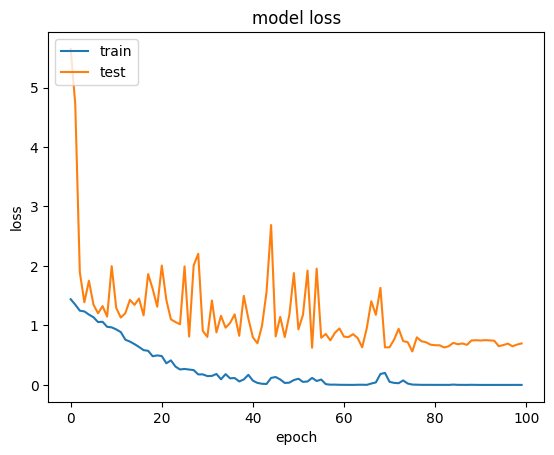

In [41]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
import json
model_json = model.to_json()
with open("C://Users//91829//Desktop//Project 7th Sem//Prediction Data//model.json", "w") as json_file:
    json_file.write(model_json)

In [43]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
loaded_model = tf.keras.models.load_model("C://Users//91829//Desktop//Project 7th Sem//Prediction Data//Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 83.75%


In [44]:
len(data2_df)


400

In [45]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]

test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data2_df.label)
lb = LabelEncoder()
test_valid_lb = keras.utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 24.70it/s]


In [46]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

25/25 [==============================] - 1s 39ms/step


In [47]:
preds

array([[1.9022189e-04, 9.8637277e-01, 2.8240588e-06, 8.2777007e-07,
        1.3433364e-02],
       [3.2452201e-05, 9.8529172e-01, 1.8592940e-06, 3.1032371e-06,
        1.4670935e-02],
       [4.1237467e-06, 9.9764436e-01, 4.4957393e-09, 6.8773204e-08,
        2.3514214e-03],
       ...,
       [1.0233723e-04, 1.5735428e-06, 9.9904948e-01, 8.3929254e-04,
        7.3195492e-06],
       [2.5191628e-06, 8.6132914e-09, 9.9994504e-01, 2.4621961e-06,
        4.9890194e-05],
       [8.7864462e-09, 6.8897926e-12, 9.9992085e-01, 8.9337195e-09,
        7.9088182e-05]], dtype=float32)

In [48]:
preds1=preds.argmax(axis=1)
preds1

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 0, 4, 4,
       4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 0, 0, 3, 3, 3, 3, 0, 0, 4, 0, 4, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2,
       2, 0, 3, 4, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 0, 3, 0, 3, 3, 3, 3, 3,
       0, 4, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 0, 4, 4, 4,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 4, 4, 4, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 4, 3, 3, 3, 0, 4, 0, 0, 0, 0,

In [49]:
abc = preds1.astype(int).flatten()
print(abc)

[1 1 1 1 1 1 1 1 0 3 3 3 3 3 3 3 4 4 4 0 4 4 4 4 0 0 0 0 0 0 0 0 2 2 0 2 2
 2 2 2 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2
 2 0 0 2 0 2 1 1 1 1 1 1 1 1 3 0 0 3 3 3 3 0 0 4 0 4 4 0 0 0 2 0 0 0 0 0 0
 2 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 3 3 0 0 3 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0
 0 0 0 0 4 2 2 0 3 4 0 2 0 0 1 1 0 1 1 1 0 3 0 3 3 3 3 3 0 4 0 0 4 4 4 4 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 3 3 3 3 0 4 4 4 0 4
 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 4 4 4
 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 1 1 1 1 1 1 1 0 0 0 4 3 3 3 0
 4 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 1 1 1 1 1 1 1 1 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 3 3
 0 0 3 3 3 3 4 4 0 4 4 4 0 4 0 0 0 0 0 0 0 0 2 3 2 2 2 2 2 2]


In [50]:
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_angry
9,male_happy


In [51]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_happy
9,male_happy


In [52]:
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,male_calm,male_calm
1,male_calm,male_calm
2,male_calm,male_calm
3,male_calm,male_calm
4,male_calm,male_calm
...,...,...
395,male_fearful,male_fearful
396,male_fearful,male_fearful
397,male_fearful,male_fearful
398,male_fearful,male_fearful


In [53]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_angry,80
male_calm,80
male_fearful,80
male_happy,80
male_sad,80


In [54]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,181
male_calm,65
male_fearful,38
male_happy,57
male_sad,59


In [55]:
finaldf.to_csv('C://Users//91829//Desktop//Project 7th Sem//Predictions.csv', index=False)

In [62]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    f1score=10

In [57]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100


82.5

In [64]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[78,  0,  2,  0,  0],
       [15, 65,  0,  0,  0],
       [40,  0, 36,  2,  2],
       [24,  0,  0, 55,  1],
       [24,  0,  0,  0, 56]], dtype=int64)

In [65]:
class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']

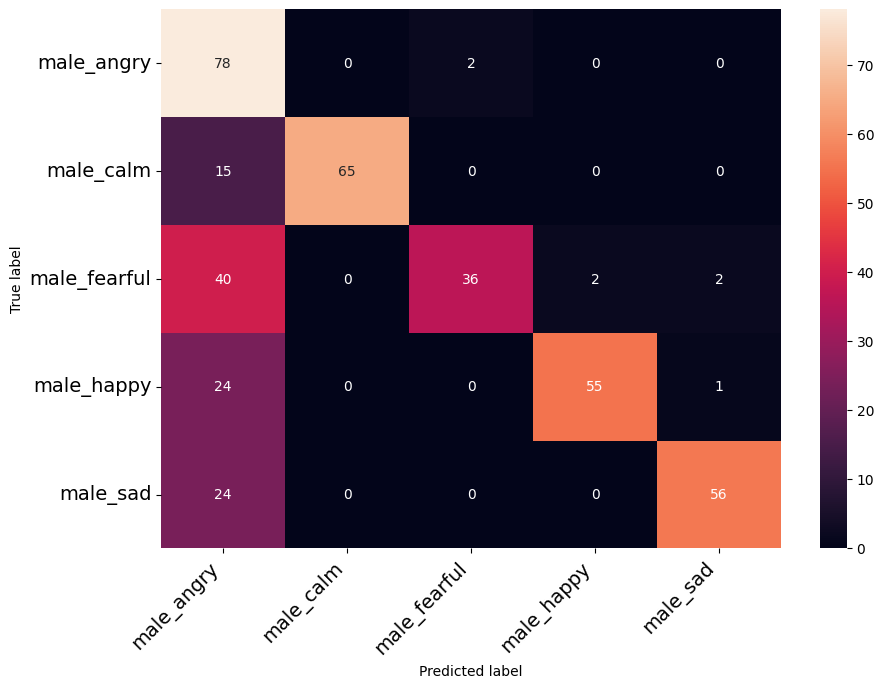

In [66]:
print_confusion_matrix(c, class_names)